In [12]:
from pathlib import Path
import numpy as np
import tifffile
from skimage.exposure import match_histograms, rescale_intensity
from skimage.restoration import calibrate_denoiser, denoise_tv_chambolle
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import time
#import cupy as cp #NEED FOR GPU!!!!!!
#from mcsim.analysis import sim_reconstruction as sim


def optical_sectioning_sim_90deg(imgs, method):
    # separate 0, 90, 180 images
    #I1 = imgs[0,:]
    #I2 = imgs[1,:]
    #I3 = imgs[2,:]
    I1 = imgs[0,:]
    I2 = imgs[1,:]
    I3 = imgs[2,:]

    # calculate OS image using law of sines to recover in-focus intensities
    if method == 'DD':
        os_image = 0.5 * np.sqrt((2*I2 - I1 - I3)**2 + (I3 - I1)**2) 

    elif method == 'NEIL':
        os_image = np.sqrt(((I1-I2)**2)+((I1-I3)**2)+((I2-I3)**2))

    else:
        print('Invalid method. Please choose either DD or NEIL')  
    
    return os_image

def optical_sectioning_sim_90deg_I(imgs, method, flag):
    # separate 0, 90, 180 images
    if flag == 0:
        I1 = imgs[0,:]
        I2 = imgs[1,:]
        I3 = imgs[2,:]
    elif flag == 1:
        I1 = imgs[2,:]
        I2 = imgs[0,:]
        I3 = imgs[1,:]
    elif flag == 2:
        I1 = imgs[1,:]
        I2 = imgs[2,:]
        I3 = imgs[0,:]


    # calculate OS image using law of sines to recover in-focus intensities
    if method == 'DD':
        os_image = 0.5 * np.sqrt((2*I2 - I1 - I3)**2 + (I3 - I1)**2) 

    elif method == 'NEIL':
        os_image = np.sqrt(((I1-I2)**2)+((I1-I3)**2)+((I2-I3)**2))

    else:
        print('Invalid method. Please choose either DD or NEIL')  
    
    return os_image



def match_histogram_z(imgs, nangles, nphases):
    for ii in range(nangles):
        for jj in range(1, nphases):
            imgs[ii, jj,:] = match_histograms(imgs[ii, jj,:], imgs[ii, 0,:])

    return imgs

def match_histogram_z_I(imgs, nangles, nphases, flag):
    for ii in range(nangles):
        for jj in range(0, nphases):
            if jj != flag:
               imgs[ii, jj,:] = match_histograms(imgs[ii, jj,:], imgs[ii, flag,:])

    return imgs

def run_SIM(file_Name, method):
    dx = 1.0
    dz = 1.0
    excitation_wl = 0.470
    emission_wl = 0.520
    na = 0.3
    nangles = 1
    nphases = 3

    # load the data and reshape
    input_file_path = Path(file_Name)
    #input_file_path = Path("c://users//researcher/downloads/TRYSIM_8.tif")
    root_path = input_file_path.parents[0]
    img = tifffile.imread(input_file_path)

    # TO DO: correctly parse metadata / load multiple images loop over timelapse
    nt = 1
    nz = int(img.shape[0]/(nangles*nphases))
    ny = img.shape[1]
    nx = img.shape[2]
    img_reshape = np.reshape(img,[nz,nangles,nphases,ny,nx])

    # turn image into float
    img_reshape = img_reshape.astype(np.float32)

    # create storage variables
    widefield = np.zeros((nz,ny,nx),dtype=np.float32)
    os_sim_per_angle = np.zeros((nangles,ny,nx),dtype=np.float32)
    os_sim_angle = np.zeros((nangles,nz,ny,nx),dtype=np.float32)
    os_sim = np.zeros((nz,ny,nx),dtype=np.float32)


    # loop over all timepoints
    for t_idx in tqdm(range(0,nt),desc='time',leave=True):

        # check if there is more than one time point
        if nt==1:
            imgs_to_process = img_reshape[:]
        else:
            imgs_to_process = img_reshape[t_idx,:]
        
        for z_idx in tqdm(range(0,nz),desc='SIM OS per z plane',leave=False):
            
            # match histograms for each phase & angle at this z plane
            matched_imgs = match_histogram_z(imgs_to_process[z_idx,:],nangles,nphases)
            #matched_imgs = imgs_to_process[z_idx,:]

            # calculate widefield image at this z plane
            widefield[z_idx,:] = np.nanmean(matched_imgs, axis=(0, 1))
            #print(matched_imgs.shape)
            if method == 'DD':
                matched_imgs_DD = matched_imgs[:,::2,:,:]
                widefield[z_idx,:] = np.nanmean(matched_imgs_DD,axis=(0, 1))

            
            # calculate os-sim image for each angle at this z plane
            for angle_idx in range(0,nangles):
                os_sim_per_angle[angle_idx,:]=optical_sectioning_sim_90deg(matched_imgs[angle_idx,:],method)
                os_sim_angle[angle_idx,z_idx,:]=os_sim_per_angle[angle_idx,:]
            # average os-sim over all angles at this z plane
            os_sim[z_idx,:] = np.nanmean(os_sim_per_angle,axis=0)


        # rescale to 16-bit for output
        widefield = rescale_intensity(widefield,out_range=(0,65535)).astype(np.uint16)
        os_sim = rescale_intensity(os_sim,out_range=(0,65535)).astype(np.uint16)

        return widefield, os_sim
    


In [52]:
def run_SIM_Interleaved(file_Name, method):
    dx = 1.0
    dz = 1.0
    excitation_wl = 0.470
    emission_wl = 0.520
    na = 0.3
    nangles = 1
    nphases = 3

    # load the data and reshape
    input_file_path = Path(file_Name)
    #input_file_path = Path("c://users//researcher/downloads/TRYSIM_8.tif")
    root_path = input_file_path.parents[0]
    img = tifffile.imread(input_file_path)
    print(img.shape)
    

    # TO DO: correctly parse metadata / load multiple images loop over timelapse
    nt = 1
    nz = int(img.shape[0]/(nangles*nphases))
    ny = img.shape[1]
    nx = img.shape[2]



    img1 = img[0:3*nz,:,:]
    img2 = img[1:3*nz-2,:,:]
    img3 = img[2:3*nz-1,:,:]

    print(img1.shape)

    nz = nz


    img1_reshape = np.reshape(img1,[nz,nangles,nphases,ny,nx])
    img2_reshape = np.reshape(img2,[nz-1,nangles,nphases,ny,nx])
    img3_reshape = np.reshape(img3,[nz-1,nangles,nphases,ny,nx])

    # turn image into float
    #img_reshape = img_reshape.astype(np.float32)
    img1_reshape = img1_reshape.astype(np.float32)
    img2_reshape = img2_reshape.astype(np.float32)
    img3_reshape = img3_reshape.astype(np.float32)

    # create storage variables
    widefield1 = np.zeros((nz,ny,nx),dtype=np.float32)
    os_sim_per_angle1 = np.zeros((nangles,ny,nx),dtype=np.float32)
    os_sim_angle1 = np.zeros((nangles,nz,ny,nx),dtype=np.float32)
    os_sim1 = np.zeros((nz,ny,nx),dtype=np.float32)

      
    widefield2 = np.zeros((nz,ny,nx),dtype=np.float32)
    os_sim_per_angle2 = np.zeros((nangles,ny,nx),dtype=np.float32)
    os_sim_angle2 = np.zeros((nangles,nz,ny,nx),dtype=np.float32)
    os_sim2 = np.zeros((nz,ny,nx),dtype=np.float32)

    widefield3 = np.zeros((nz,ny,nx),dtype=np.float32)  
    os_sim_per_angle3 = np.zeros((nangles,ny,nx),dtype=np.float32)
    os_sim_angle3 = np.zeros((nangles,nz,ny,nx),dtype=np.float32)
    os_sim3 = np.zeros((nz,ny,nx),dtype=np.float32)



    # loop over all timepoints
    for t_idx in tqdm(range(0,nt),desc='time',leave=False):

        # check if there is more than one time point
        if nt==1:
            imgs_to_process1 = img1_reshape[:]
            imgs_to_process2 = img2_reshape[:]
            imgs_to_process3 = img3_reshape[:]
        else:
            imgs_to_process = img1_reshape[t_idx,:]
        
        for z_idx in tqdm(range(0,nz-1),desc='SIM OS per z plane',leave=True):
            
            # match histograms for each phase & angle at this z plane
            
            matched_imgs1 = match_histogram_z_I(imgs_to_process1[z_idx,:],nangles,nphases,0)
            matched_imgs2 = match_histogram_z_I(imgs_to_process2[z_idx,:],nangles,nphases,2)
            matched_imgs3 = match_histogram_z_I(imgs_to_process3[z_idx,:],nangles,nphases,1)
            
            #matched_imgs1 = imgs_to_process1[z_idx,:]
            #matched_imgs2 = imgs_to_process2[z_idx,:]
            #matched_imgs3 = imgs_to_process3[z_idx,:]


            # calculate widefield image at this z plane
            widefield1[z_idx,:] = np.nanmean(matched_imgs1, axis=(0, 1))
            widefield2[z_idx,:] = np.nanmean(matched_imgs2, axis=(0, 1))
            widefield3[z_idx,:] = np.nanmean(matched_imgs3, axis=(0, 1))
            #print(matched_imgs.shape)
            """
            if method == 'DD':
                matched_imgs_DD = matched_imgs[:,::2,:,:]
                widefield[z_idx,:] = np.nanmean(matched_imgs_DD,axis=(0, 1))
            """
            
            # calculate os-sim image for each angle at this z plane
            for angle_idx in range(0,nangles):
                os_sim_per_angle1[angle_idx,:]=optical_sectioning_sim_90deg_I(matched_imgs1[angle_idx,:],method,0)
                os_sim_angle1[angle_idx,z_idx,:]=os_sim_per_angle1[angle_idx,:]

                os_sim_per_angle2[angle_idx,:]=optical_sectioning_sim_90deg_I(matched_imgs2[angle_idx,:],method,1)
                os_sim_angle2[angle_idx,z_idx,:]=os_sim_per_angle2[angle_idx,:]

                os_sim_per_angle3[angle_idx,:]=optical_sectioning_sim_90deg_I(matched_imgs3[angle_idx,:],method,2)
                os_sim_angle3[angle_idx,z_idx,:]=os_sim_per_angle3[angle_idx,:]




            # average os-sim over all angles at this z plane
            os_sim1[z_idx,:] = np.nanmean(os_sim_per_angle1,axis=0)
            os_sim2[z_idx,:] = np.nanmean(os_sim_per_angle2,axis=0)
            os_sim3[z_idx,:] = np.nanmean(os_sim_per_angle3,axis=0)

    os_img = np.zeros((3*nz,ny,nx),dtype=np.float32)
    os_img[0::3,:,:] = os_sim1
    os_img[1::3,:,:] = os_sim2
    os_img[2::3,:,:] = os_sim3 

    wf_img = np.zeros((3*nz,ny,nx),dtype=np.float32)
    wf_img[0::3,:,:] = widefield1
    wf_img[1::3,:,:] = widefield2
    wf_img[2::3,:,:] = widefield3 
    

    os_img = rescale_intensity(os_img,out_range=(0,65535)).astype(np.uint16)
    wf_img = rescale_intensity(wf_img,out_range=(0,65535)).astype(np.uint16)




    """
    # rescale to 16-bit for output
    widefield1 = rescale_intensity(widefield1,out_range=(0,65535)).astype(np.uint16)
    widefield2 = rescale_intensity(widefield2,out_range=(0,65535)).astype(np.uint16)
    widefield3 = rescale_intensity(widefield3,out_range=(0,65535)).astype(np.uint16)


    os_sim1 = rescale_intensity(os_sim1,out_range=(0,65535)).astype(np.uint16)
    os_sim2 = rescale_intensity(os_sim2,out_range=(0,65535)).astype(np.uint16)
    os_sim3 = rescale_intensity(os_sim3,out_range=(0,65535)).astype(np.uint16)
    """

    return  os_img, wf_img

In [2]:
"""
def get_Wicker_Phases(imgs):
    na = 1.0 # numerical aperture
    dxy = 0.225 # um -> *4 for binning
    wavelength = 0.515 # um

    nz = 1
    nangles = 1
    nphases = 3
    ny = imgs.shape[1]
    nx = imgs.shape[2]
    #imgs = np.reshape(imgs,[nangles,nphases,ny,nx])

    imgset = sim.SimImageSet.initialize({"pixel_size": dxy,
                                     "na": na,
                                     "wavelength": wavelength},
                                     imgs,
                                     otf=None,
                                     wiener_parameter=0.3,
                                     frq_estimation_mode="band-correlation",
                                     #frq_guess=frqs_gt, # todo: can add frequency guesses for more reliable fitting
                                     phase_estimation_mode="wicker-iterative",

                                     #phase_estimation_mode="real-space",
                                     phases_guess=np.array([[0, 2*np.pi / 3, 4 * np.pi / 3],
                                                            [0, 2*np.pi / 3, 4 * np.pi / 3],
                                                            [0, 2*np.pi / 3, 4 * np.pi / 3]]),

                                     combine_bands_mode="fairSIM",
                                     fmax_exclude_band0=0.4,
                                     normalize_histograms=False,
                                     background=0,
                                     gain=1,
                                     use_gpu=False,
                                     print_to_terminal=False,
                                     )



    imgset.reconstruct()
    phases = imgset.phases - np.expand_dims(imgset.phase_corrections, axis=1)
    print(phases)

    # ADD pLOT FIGS FOR DEBBUG -> FREQUENCY FINDING DIAGNOSTIC
    # CHECK fq WQITH ESTIMATE PARAMETERS FUNCTION
    # lOOK at oPTICAL SECTIONING FUNCTION 

    return phases

def OS_SIM_NEIL_MC(imgs, phases):

    nangles = 1
    nphases = 3
    img_reshape = imgs.astype(np.float32)
    #matched_imgs = match_histogram_z(img_reshape[0,:],nangles,nphases)
    matched_imgs = img_reshape[0,:]

    phi0 = phases[0,0]
    phi1 = phases[0,1]
    phi2 = phases[0,2]


    I0 = matched_imgs[0,:,:]
    I1 = matched_imgs[1,:,:]
    I2 = matched_imgs[2,:,:]







    os_image_MC = np.sqrt(((I0-I1)**2)+(((I1-I2)/np.tan((phi1-phi2)/2))-((I2-I0)/np.tan((phi2-phi0)/2)))**2)
    os_sim = rescale_intensity(os_image_MC,out_range=(0,65535)).astype(np.uint16)

    return os_sim


def run_SIM_MC(file_Name):
    dx = 1.0
    dz = 1.0
    excitation_wl = 0.470
    emission_wl = 0.520
    na = 0.3
    nangles = 1
    nphases = 3

    # load the data and reshape
    input_file_path = Path(file_Name)
    root_path = input_file_path.parents[0]
    img = tifffile.imread(input_file_path)

    # TO DO: correctly parse metadata / load multiple images loop over timelapse
    nz = 1
    nt = int(img.shape[0]/(nangles*nphases))
    ny = img.shape[1]
    nx = img.shape[2]
    img_reshape = np.reshape(img,[nt,nangles,nphases,ny,nx])

    # turn image into float
    img_reshape = img_reshape.astype(np.float32)

    # create storage variables
    widefield = np.zeros((nt,ny,nx),dtype=np.float32)
    os_sim = np.zeros((nt,ny,nx),dtype=np.float32)

    t = 0
    errors = 0
    while t < nt:
        print(t)
         
        try:
            phases = get_Wicker_Phases(img_reshape[t,:,:,:,:])
        except:
            phases = np.array([[0, 2*np.pi / 3, 4 * np.pi / 3]])
            errors = errors + 1    
        
        #phases = np.array([[0, 2*np.pi / 3, 4 * np.pi / 3]])                               
        os_sim[t,:,:] = OS_SIM_NEIL_MC(img_reshape[t,:,:,:,:], phases)
        t = t + 1
    print(errors)

    return os_sim
"""


In [5]:

def seperate_phase(imgs):
    p1 = imgs[0::3,:,:]
    p2 = imgs[1::3,:,:]
    p3 = imgs[2::3,:,:]
    return p1, p2, p3

def save_phases(filename):
    img = tifffile.imread(filename)
    p1,p2,p3 = seperate_phase(img)
    tifffile.imsave(filename+'_p1.tif', p1)
    tifffile.imsave(filename+'_p2.tif', p2)
    tifffile.imsave(filename+'_p3.tif', p3)



#filename = 'O:\\workingdirectory\\072623_PVG8\\best_sofar\\\SIM900_b4_GOOD.tif'
#save_phases(filename)


def interleave_stacks(filename_p1,filename_p2, filename_p3):
    p1 = tifffile.imread(filename_p1)
    p2 = tifffile.imread(filename_p2)
    p3 = tifffile.imread(filename_p3)
    #p4 = tifffile.imread(filename_p4)
    img = np.zeros((p1.shape[0]*3,p1.shape[1],p1.shape[2]),dtype=np.uint16)
    img[0::3,:,:] = p1
    img[1::3,:,:] = p2
    img[2::3,:,:] = p3
    #img[3::4,:,:] = p4
    tifffile.imsave(filename_p1[:-6]+'_interleaved.tif', img)

filename_p1 = '101123\\cy01\\200n120_16X\_1\P1_mc.tif'
filename_p2 = '101123\\cy01\\200n120_16X\_1\P2_mc.tif'
filename_p3 = '101123\\cy01\\200n120_16X\_1\P3_mc.tif'
#filename_p4 = 'O:\\workingdirectory\\090823\\PVG8\\DD40_100\\DD40_100_C_P4_MC.tif'

interleave_stacks(filename_p1,filename_p2, filename_p3)

    

In [ ]:

"""
file_Name = 'O:\\workingdirectory\\SIM_GCAMP\\test_090123_GCAMP\\_1\\try2_n18.tif'
output_file_Name = 'O:\\workingdirectory\\SIM_GCAMP\\test_090123_GCAMP\\_1\\try2_n18_REC.tif'
os_MC = run_SIM_MC(file_Name)
tifffile.imwrite(output_file_Name,os_MC)
"""


In [8]:
def save_Reconstructions(widefield,os_sim, input_file):
    output_file_path_SIM = Path(input_file.rsplit('.', 1)[0] + '_M_SIM_Reconstruction.tif')
    output_file_path_pWF = Path(input_file.rsplit('.', 1)[0] + '_M_pWF_Reconstruction.tif')
    tifffile.imwrite(output_file_path_SIM,os_sim)
    tifffile.imwrite(output_file_path_pWF,widefield)

def save_Reconstructions_i(wf_img, os_img, input_file):
    tifffile.imwrite(input_file[:-4]+'_interleaved2_SIM_Reconstruction.tif', os_img)
    tifffile.imwrite(input_file[:-4]+'_interleaved2_pWF_Reconstruction.tif', wf_img)



In [7]:
def process_Multiple_Files(folder_Name, method):
    directory = os.fsencode(folder_Name)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".tif"):
            
            print(file)
            widefield, os_sim = run_SIM(folder_Name + '\\' + filename, method)
            save_Reconstructions(widefield,os_sim, folder_Name +'\\'+ filename)
            continue
        else:
            continue
        

In [13]:
folder_Name = '101123\\cy01\\200n120_16X\_1'

filename = 'p1__interleaved.tif'
method = 'NEIL'

widefield, os_sim = run_SIM(folder_Name + '\\' + filename, method)
save_Reconstructions(widefield,os_sim, folder_Name +'\\' + method+ '_' + filename)

time:   0%|          | 0/1 [06:52<?, ?it/s]


KeyboardInterrupt: 

In [54]:
folder_Name = 'O:\\workingdirectory\\090823\\PVG8\\DD40_100'

filename = 'DD40_100_C_MC_raw_no270.tif'
method = 'DD'

os_img, wf_img = run_SIM_Interleaved(folder_Name + '\\' + filename, method)
save_Reconstructions_i(wf_img, os_img,  folder_Name +'\\' + method+ '_1_' + filename)

(8136, 672, 619)
(8136, 672, 619)


SIM OS per z plane: 100%|██████████| 2711/2711 [16:34<00:00,  2.72it/s]


In [35]:
save_Reconstructions_i(widefield1, widefield2, widefield3, os_sim1, os_sim2,os_sim3, folder_Name +'\\' + method+ '_' + filename)

In [4]:
#process_Multiple_Files('Ace_0601','DD')

<tifffile.TiffFile 'Ace_1550_1.tif'> OME series failed to read '_1_MMStack_Pos0.ome.tif'. Missing data are zeroed


b'Ace_1550_1.tif'


<tifffile.TiffFile 'Ace_1550_1.tif'> OME series failed to read 3000 files
time:   0%|          | 0/1 [00:03<?, ?it/s]
<tifffile.TiffFile 'Ace_1550_2.tif'> OME series failed to read '_1_MMStack_Pos0.ome.tif'. Missing data are zeroed


b'Ace_1550_2.tif'


<tifffile.TiffFile 'Ace_1550_2.tif'> OME series failed to read 3000 files
time:   0%|          | 0/1 [00:03<?, ?it/s]


b'Ace_1550_3.tif'


time:   0%|          | 0/1 [00:10<?, ?it/s]


b'Ace_1550_4.tif'


<tifffile.TiffFile 'Ace_1550_4.tif'> OME series failed to read '_1_MMStack_Pos0.ome.tif'. Missing data are zeroed
<tifffile.TiffFile 'Ace_1550_4.tif'> OME series failed to read 9000 files
time:   0%|          | 0/1 [00:10<?, ?it/s]


b'Ace_2220_1.tif'


<tifffile.TiffFile 'Ace_2220_1.tif'> OME series failed to read '_1_MMStack_Pos0.ome.tif'. Missing data are zeroed
<tifffile.TiffFile 'Ace_2220_1.tif'> OME series failed to read 9000 files
time:   0%|          | 0/1 [00:01<?, ?it/s]


b'Ace_2220_2.tif'


<tifffile.TiffFile 'Ace_2220_2.tif'> OME series failed to read '_1_MMStack_Pos0.ome.tif'. Missing data are zeroed
<tifffile.TiffFile 'Ace_2220_2.tif'> OME series failed to read 9000 files
time:   0%|          | 0/1 [00:05<?, ?it/s]


b'Ace_2220_3.tif'


<tifffile.TiffFile 'Ace_2220_3.tif'> OME series failed to read '_1_MMStack_Pos0.ome.tif'. Missing data are zeroed
<tifffile.TiffFile 'Ace_2220_3.tif'> OME series failed to read 9000 files
time:   0%|          | 0/1 [00:04<?, ?it/s]


b'Ace_2220_4.tif'


<tifffile.TiffFile 'Ace_2220_4.tif'> OME series failed to read '_1_MMStack_Pos0.ome.tif'. Missing data are zeroed
<tifffile.TiffFile 'Ace_2220_4.tif'> OME series failed to read 9000 files
time:   0%|          | 0/1 [00:01<?, ?it/s]


In [1]:
import time
import numpy as np
#import cupy as cp
from pathlib import Path
import tifffile
from mcsim.analysis import sim_reconstruction as sim

In [46]:

file_Name = 'O:\\workingdirectory\\071823\\SIMtest\\test_333FPS_2_1\\test3c.tif'


input_file_path = Path(file_Name)
imgs = tifffile.imread(input_file_path)

na = 1.0 # numerical aperture
dxy = 0.225 # um
wavelength = 0.515 # um

nz = 1
nangles = 1
nphases = 3
ny = imgs.shape[1]
nx = imgs.shape[2]

imgs = np.reshape(imgs,[nangles,nphases,ny,nx])

print(imgs.shape)



(1, 3, 244, 244)


initialization took 0.01s
starting parameter estimation...
estimating 1 frequencies using mode band-correlation took 0.16s


c:\Users\Researcher\anaconda3\envs\mcSIM_Dev_try\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Researcher\anaconda3\envs\mcSIM_Dev_try\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Researcher\anaconda3\envs\mcSIM_Dev_try\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


estimated peak-to-noise ratio in 0.00s
estimated 3 phases using mode wicker-iterative in 0.17s
estimated global phases and modulation depths in 0.06s
replaced modulation depth for angle 0 because estimated value was less than allowed minimum, 0.085 < 0.500
parameter estimation took 0.41s
Computing SIM-OS image took 0.00s
combining bands took 0.02s
reconstruction took 0.04s


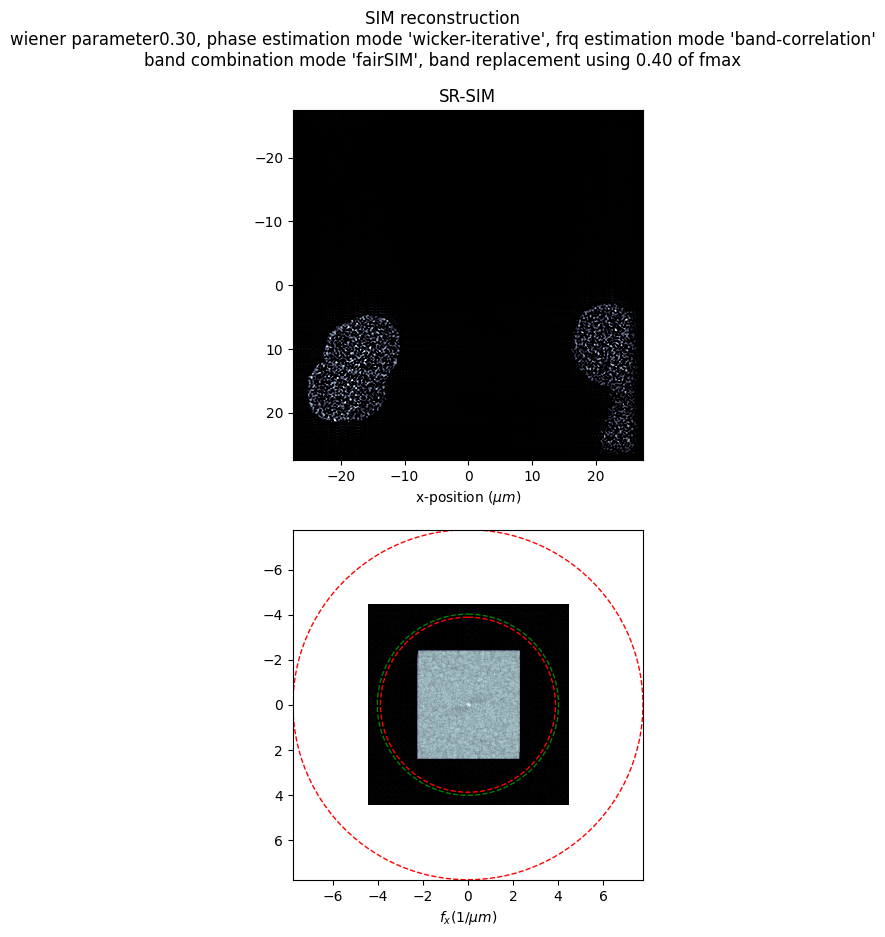

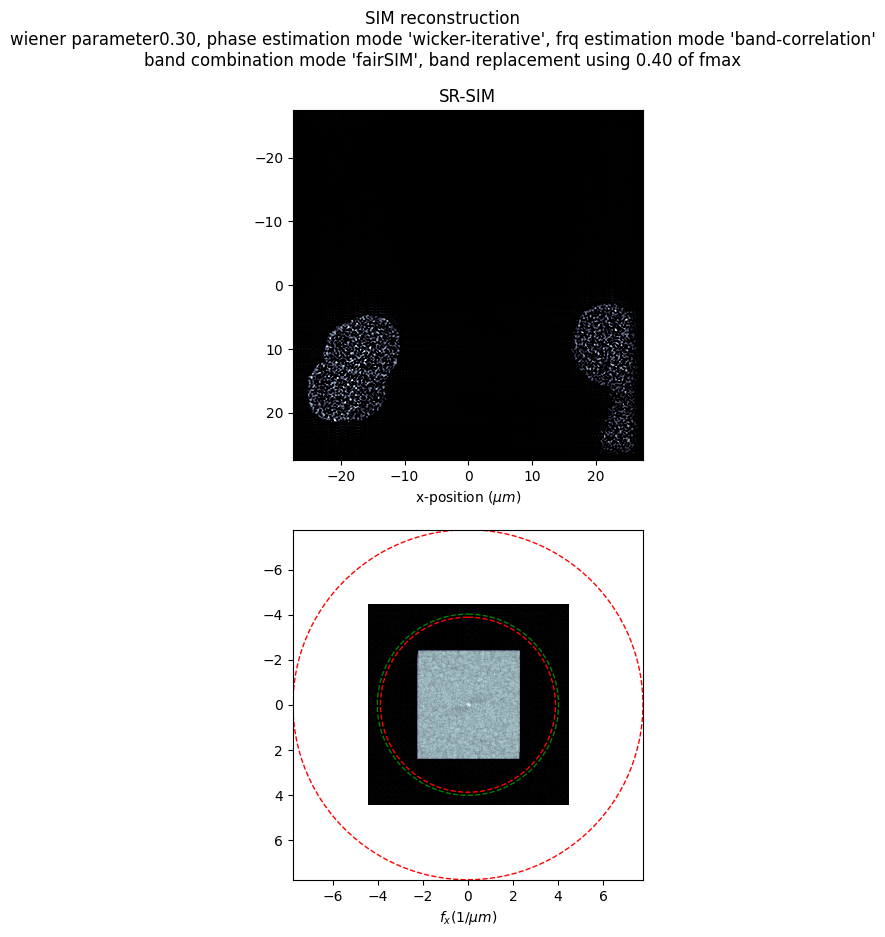

In [25]:
imgset = sim.SimImageSet.initialize({"pixel_size": dxy,
                                     "na": na,
                                     "wavelength": wavelength},
                                     imgs,
                                     otf=None,
                                     wiener_parameter=0.3,
                                     frq_estimation_mode="band-correlation",
                                     # frq_guess=frqs_gt, # todo: can add frequency guesses for more reliable fitting
                                     phase_estimation_mode="wicker-iterative",
                                     phases_guess=np.array([[0, 2*np.pi / 3, 4 * np.pi / 3],
                                                            [0, 2*np.pi / 3, 4 * np.pi / 3],
                                                            [0, 2*np.pi / 3, 4 * np.pi / 3]]),
                                     combine_bands_mode="fairSIM",
                                     fmax_exclude_band0=0.4,
                                     normalize_histograms=False,
                                     background=100,
                                     gain=1,
                                     use_gpu=False,
                                     )


# this included parameter estimation
imgset.reconstruct(compute_os=True)
# extract estimated parameters
frqs = imgset.frqs
phases = imgset.phases - np.expand_dims(imgset.phase_corrections, axis=1)
mod_depths = imgset.mod_depths
otf = imgset.otf

imgset.plot_reconstruction()


In [52]:
img_reshape = imgs.astype(np.float32)
matched_imgs = match_histogram_z(img_reshape[0,:],nangles,nphases)

phi0 = phases[0,0]
phi1 = phases[0,1]
phi2 = phases[0,2]


I0 = matched_imgs[0,:,:]
I1 = matched_imgs[1,:,:]
I2 = matched_imgs[2,:,:]



output_file_Name = 'O:\\workingdirectory\\071823\\SIMtest\\test_333FPS_2_1\\test3_tryMC2.tif'

os_image_MC = np.sqrt(((I0-I1)**2)+(((I1-I2)/np.tan((phi1-phi2)/2))-((I2-I0)/np.tan((phi2-phi0)/2)))**2)

os_image = np.sqrt(((I0-I1)**2)+((I0-I2)**2)+((I1-I2)**2))

os_sim = rescale_intensity(os_image_MC,out_range=(0,65535)).astype(np.uint16)

tifffile.imwrite(output_file_Name,os_sim)


